In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
import seaborn as sns
import pandas as pd

from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Load dataset choice

In [94]:
dataset = sf_inputs_discrete.Sim2DWalk
feature_maker_kwargs = {
    'feature_dim': 64, 'feature_vals': [0, 1]
    }
dataset_config = {
    'num_steps': 2000, 'num_states': 64,
    'feature_maker_kwargs': feature_maker_kwargs
    }
input_size = feature_maker_kwargs['feature_dim']
gamma = 0.95
seed = 0

# Calculate ground-truth T and M

In [95]:
np.random.seed(seed)
dset = dataset(**dataset_config)

In [96]:
state_inputs = np.argwhere(dset.state_inputs)[:,0]

In [97]:
T = np.zeros((input_size, input_size))
for idx in range(state_inputs.size-1):
    s = state_inputs[idx]
    s_prime = state_inputs[idx+1]
    T[s, s_prime] += 1
T = T/(np.sum(T, axis=1)[:,None])

In [98]:
M = np.linalg.pinv(np.eye(T.shape[0])-gamma*T)

In [99]:
# Column is a feature
feature_map = dset.feature_maker.feature_map

In [100]:
M_0 = feature_map@M[0]

# Run each model

In [132]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr': False, 'lr':1E-3,
        'eigenval_offset': 0.4
        }
    )
np.random.seed(seed)
_, loss = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma
    )
print(loss)


[   51] loss: 0.325
Time per step 0.002s, net 0.077s

[  101] loss: 0.350
Time per step 0.002s, net 0.190s

[  151] loss: 0.350
Time per step 0.003s, net 0.344s

[  201] loss: 0.352
Time per step 0.004s, net 0.534s

[  251] loss: 0.359
Time per step 0.004s, net 0.755s

[  301] loss: 0.359
Time per step 0.005s, net 1.014s

[  351] loss: 0.357
Time per step 0.006s, net 1.309s

[  401] loss: 0.360
Time per step 0.007s, net 1.648s

[  451] loss: 0.362
Time per step 0.009s, net 2.079s

[  501] loss: 0.363
Time per step 0.009s, net 2.525s

[  551] loss: 0.364
Time per step 0.010s, net 3.034s

[  601] loss: 0.364
Time per step 0.011s, net 3.569s

[  651] loss: 0.365
Time per step 0.012s, net 4.150s

[  701] loss: 0.366
Time per step 0.013s, net 4.782s

[  751] loss: 0.366
Time per step 0.014s, net 5.488s

[  801] loss: 0.366
Time per step 0.014s, net 6.186s

[  851] loss: 0.367
Time per step 0.015s, net 6.930s

[  901] loss: 0.367
Time per step 0.016s, net 7.708s

[  951] loss: 0.367
Time pe

In [ ]:
linear = Linear(input_size=input_size)
np.random.seed(seed)
_, loss = run_linear(
    '../trained_models/test/', linear, dataset,
    dataset_config, gamma=gamma, lr=1E-4
    )
print(loss)

In [103]:
mlp = MLP(input_size=input_size, hidden_size=input_size*2)
np.random.seed(seed)
_, loss = run_mlp(
    '../trained_models/test/', mlp, dataset,
    dataset_config, gamma=gamma
    )
print(loss)


[   51] loss: 0.374
Time per step 0.002s, net 0.079s

[  101] loss: 0.281
Time per step 0.002s, net 0.198s

[  151] loss: 0.201
Time per step 0.002s, net 0.316s

[  201] loss: 0.201
Time per step 0.003s, net 0.443s

[  251] loss: 0.221
Time per step 0.002s, net 0.555s

[  301] loss: 0.181
Time per step 0.003s, net 0.687s

[  351] loss: 0.156
Time per step 0.003s, net 0.822s

[  401] loss: 0.175
Time per step 0.003s, net 0.962s

[  451] loss: 0.166
Time per step 0.003s, net 1.101s

[  501] loss: 0.154
Time per step 0.003s, net 1.249s

[  551] loss: 0.150
Time per step 0.003s, net 1.403s

[  601] loss: 0.148
Time per step 0.003s, net 1.562s

[  651] loss: 0.147
Time per step 0.003s, net 1.725s

[  701] loss: 0.146
Time per step 0.004s, net 1.926s

[  751] loss: 0.147
Time per step 0.003s, net 2.100s

[  801] loss: 0.148
Time per step 0.004s, net 2.291s

[  851] loss: 0.147
Time per step 0.004s, net 2.493s

[  901] loss: 0.147
Time per step 0.004s, net 2.686s

[  951] loss: 0.147
Time pe

# Compare estimated M for individual state

In [133]:
i = 2

In [134]:
def plot_M(M_i):
    M_i = np.tile(M_i, (5,1))
    plt.figure(figsize=(8,5))
    plt.imshow(M_i)
    plt.yticks([])
    plt.show()

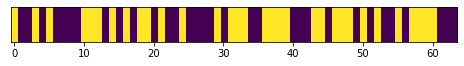

In [142]:
identity_M_i = feature_map[:,i]
plot_M(identity_M_i)

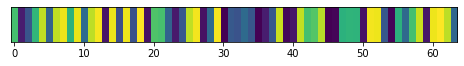

In [143]:
M_i = M[i]@feature_map
plot_M(M_i)

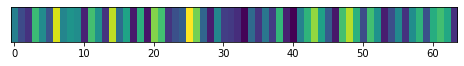

In [144]:
rnn_M_i = feature_map[i]@rnn.get_M().numpy()
plot_M(rnn_M_i)

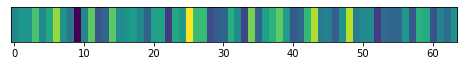

In [145]:
linear_M_i = feature_map[i]@linear.M[0].numpy()
plot_M(linear_M_i)

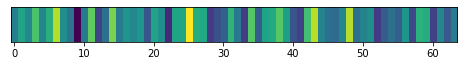

In [146]:
with torch.no_grad():
    mlp_M_i = mlp(torch.tensor(feature_map[i]).float())
plot_M(mlp_M_i.detach().numpy())

# Compare estimated M matrix

In [147]:
np.mean(np.abs(get_mlp_M(mlp) - get_ground_M(M)))

5.995558609620163

In [148]:
np.mean(np.abs(get_linear_M(linear) - get_ground_M(M)))

8.697653452313656

In [149]:
np.mean(np.abs(get_rnn_M(rnn) - get_ground_M(M)))

8.856922718286775

In [150]:
np.mean(np.abs(feature_map - get_ground_M(M)))

9.47782531095416

In [151]:
def get_mlp_M(mlp):
    input_size = feature_map.shape[0]
    M = torch.zeros(input_size, input_size)
    for idx in range(input_size):
        probe = torch.tensor(feature_map[idx]).float()
        with torch.no_grad():
            M_row = mlp(probe)
        M[idx] = M_row
    return M.numpy()

def get_linear_M(linear):
    input_size = feature_map.shape[0]
    out_M = np.zeros((input_size, input_size))
    linear_M = linear.M[0].detach().numpy()
    for idx in range(input_size):
        out_M[idx] = feature_map[idx]@linear_M
    return out_M

def get_rnn_M(rnn):
    input_size = feature_map.shape[0]
    out_M = np.zeros((input_size, input_size))
    rnn_M = rnn.get_M().numpy()
    for idx in range(input_size):
        out_M[idx] = feature_map[idx]@rnn_M
    return out_M

def get_ground_M(M):
    input_size = feature_map.shape[0]
    true_M = np.zeros((input_size, input_size))
    for idx in range(input_size):
        true_M[idx] = feature_map@M[idx]
    return true_M

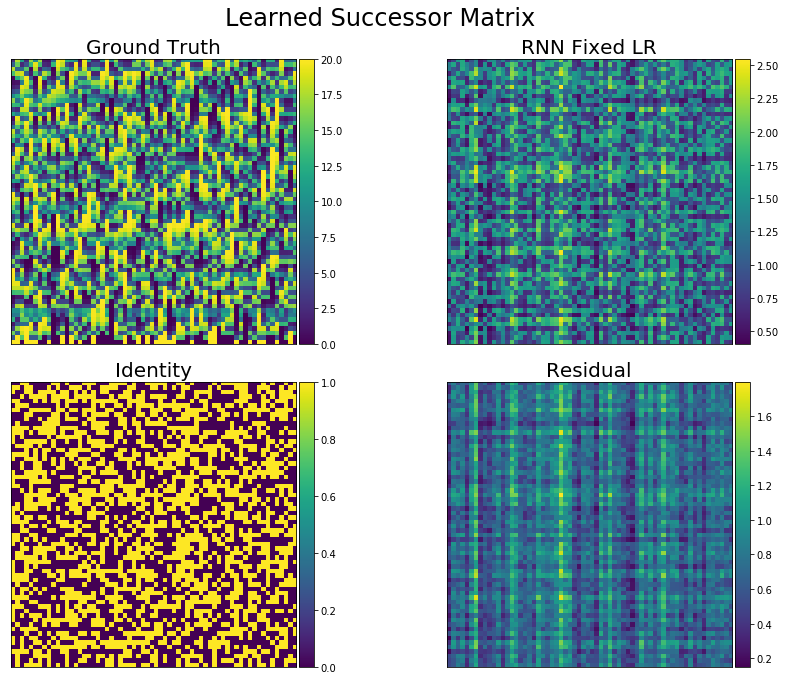

In [152]:
# Debugging RNN
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
axtitle_fontsize=20

# Ground Truth
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,0].imshow(get_ground_M(M))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,0].set_title('Ground Truth', fontsize=axtitle_fontsize)

# RNN
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,1].imshow(get_rnn_M(rnn))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,1].set_title('RNN Fixed LR', fontsize=axtitle_fontsize)

# Identity
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,0].imshow(feature_map)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,0].set_title('Identity', fontsize=axtitle_fontsize)

# Residual
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,1].imshow(get_rnn_M(rnn)-feature_map)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,1].set_title('Residual', fontsize=axtitle_fontsize)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Learned Successor Matrix", fontsize=24)
plt.tight_layout(rect=[0, 0., 1, 0.95])
plt.savefig('M_comparisons.png', dpi=150)
plt.show()

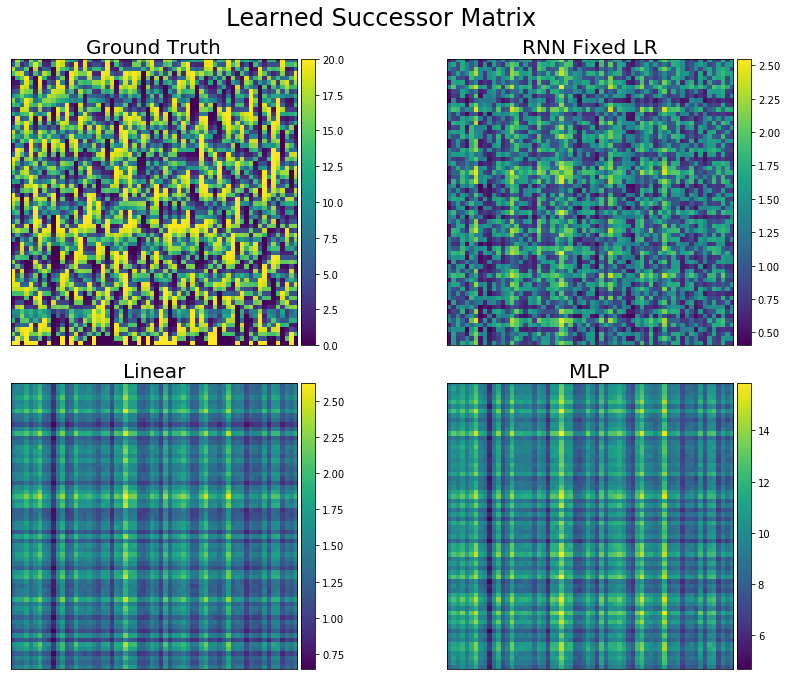

In [153]:
# Comparing Everything
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
axtitle_fontsize=20

# Ground Truth
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,0].imshow(get_ground_M(M))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,0].set_title('Ground Truth', fontsize=axtitle_fontsize)

# RNN
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,1].imshow(get_rnn_M(rnn))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,1].set_title('RNN Fixed LR', fontsize=axtitle_fontsize)

# Linear
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,0].imshow(get_linear_M(linear))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,0].set_title('Linear', fontsize=axtitle_fontsize)

# MLP
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,1].imshow(get_mlp_M(mlp))
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,1].set_title('MLP', fontsize=axtitle_fontsize)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Learned Successor Matrix", fontsize=24)
plt.tight_layout(rect=[0, 0., 1, 0.95])
plt.savefig('M_comparisons.png', dpi=150)
plt.show()

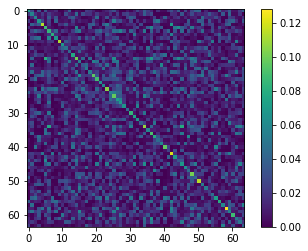

In [154]:
plt.figure()
plt.imshow(rnn.ca3.T.detach().numpy())
plt.colorbar()
plt.show()

[0.79308677 0.79525054 0.792206   0.80423677 0.8235727  0.81948155
 0.83672345 0.79815453 0.79683644 0.82148516 0.79012644 0.79188573
 0.776909   0.8031731  0.8465394  0.8040898  0.7810861  0.7867751
 0.79924875 0.8191314  0.8239748  0.7955894  0.7893285  0.8346854
 0.80892533 0.8362838  0.806621   0.8037535  0.79261535 0.77438605
 0.81061035 0.80133086 0.79870474 0.7759112  0.8401286  0.7909244
 0.83155614 0.80324197 0.77880335 0.79432505 0.80954444 0.76157576
 0.836367   0.8072769  0.78052384 0.81405115 0.7909062  0.7837645
 0.83340263 0.78560656 0.8286562  0.79145783 0.78431624 0.7709924
 0.7899291  0.7991561  0.8089905  0.79050684 0.84447306 0.8008623
 0.8105335  0.7976277  0.7909514  0.7751389 ]


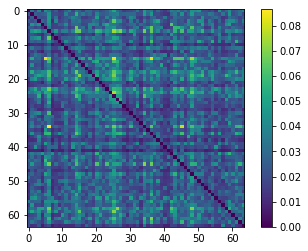

In [155]:
plt.figure()
plot_M = rnn.get_M().numpy()
print(np.diagonal(plot_M))
np.fill_diagonal(plot_M, 0)
plt.imshow(plot_M)
plt.colorbar()
plt.show()